# Dask Array

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Dask"
* https://docs.dask.org/en/latest/array.html

In [207]:
import dask.array as da
import h5py
import numpy as np
import dask
import pandas as pd
import graphviz


In [2]:
!pip install graphviz 

## Задачи для совместного разбора

1. Создайте массив размерностью 1000 на 300000, заполненный числами из стандартного нормального распределения. Исследуйте основные характеристики полученного массива. Визуализируйте граф вычисления задачи.

In [15]:
import numpy as np
import h5py
# with h5py.File("demo.h5", "w") as hdf:
#     hdf.create_dataset('arr', data=np.random.normal(0, 1, size = (1000, 300_000)))

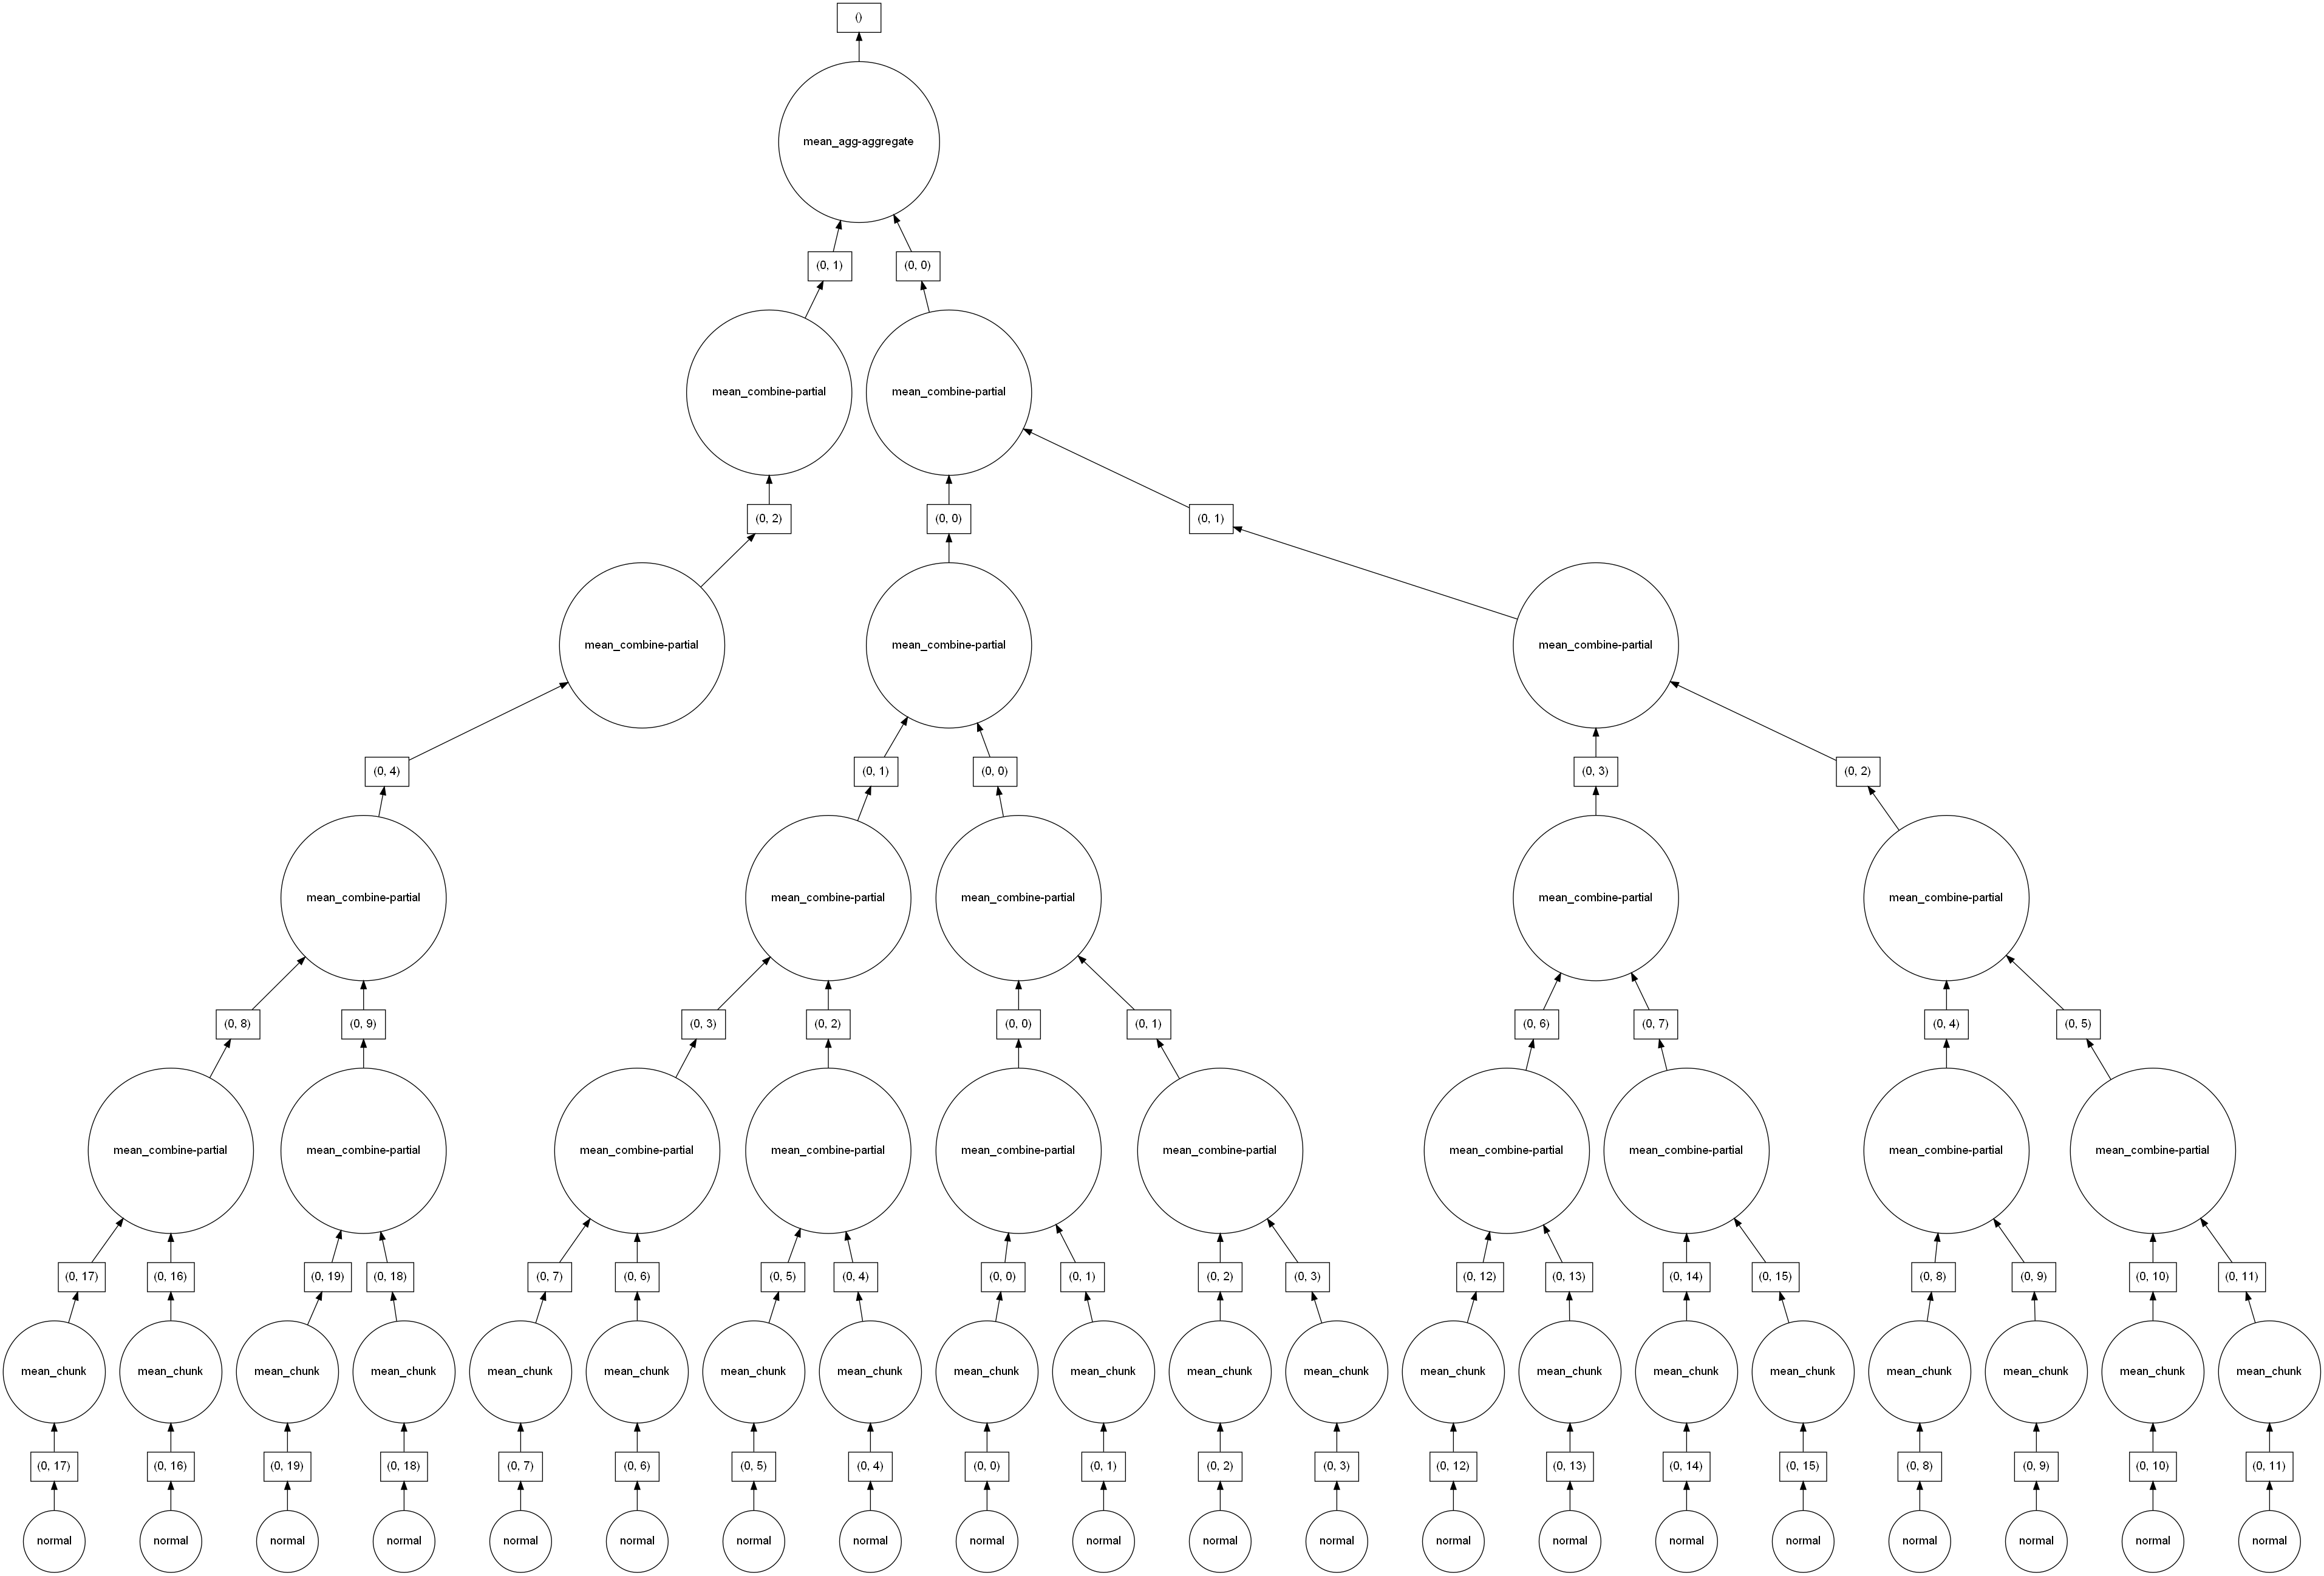

2. Посчитайте сумму квадратов элементов массива, созданного в задаче 1. Создайте массив `np.array` такого же размера и сравните скорость решения задачи с использование `da.array` и `np.array`

In [4]:
with h5py.File("demo.h5", "r") as hdf:
    hdf = h5py.File("demo.h5", "r")
    dset = hdf["arr"]
arr = da.from_array(dset, chunks=(1000, 30000))
arr

dask.array<array, shape=(1000, 300000), dtype=float64, chunksize=(1000, 30000), chunktype=numpy.ndarray>

In [7]:
%%time
arr.mean()

Wall time: 3.02 ms


dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [8]:
%%time
arr.mean().compute()

Wall time: 9 s


6.926156126692252e-06

In [10]:
arr1 = arr * 2
s = arr1.sum()
m = arr1.mean()



In [11]:
%%time
arr1 = arr * 2
s = arr1.sum()
print(s.compute())
m = arr1.mean()
print(m.compute())



4155.693676015351
1.3852312253384504e-05
Wall time: 22.3 s


In [205]:
%%time
arr1 = arr * 2
s = arr1.sum()
m = arr1.mean()
dask.compute(
    s, m
)

s.visualize()

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Лабораторная работа 11

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В ходе выполнения все операции вычислений (расчет средних значений, расчет косинусной близости и т.д.) проводятся над `dask.array` и средствами пакета `dask`, если в задании не сказано обратного. Переход от `dask.array` к `numpy.array` или `pd.DataFrame` возможен исключительно для демонстрации результата в конце решения задачи. Если в задаче используются результаты выполнения предыдущих задач, то подразумевается, что вы используете результаты в виде `dask.array` (то есть то, что было получено до вызова `compute`, а не после).

In [83]:
dask.__version__

'2.20.0'

In [81]:
!pip install  --upgrade dask

  Attempting uninstall: dask
    Found existing installation: dask 2.20.0
    Uninstalling dask-2.20.0:
      Successfully uninstalled dask-2.20.0


1\. Считайте датасет `embeddings` из файла `recipe_embeddings.h5` в виде `dask.array`. Выведите на экран основную информацию о массиве: размер, форму, тип, количество и размер сегментов. 

In [109]:
with h5py.File('recipe_embeddings.h5',
         'r') as hdf:
    hdf = h5py.File('recipe_embeddings.h5', 'r')
    data = hdf['embeddings']
    arr = da.array(data)

In [110]:
arr.mean().compute()

0.0023777566

In [219]:
# with h5py.File("demo.h5", "r") as hdf:
#     hdf = h5py.File("demo.h5", "r")
#     dset = hdf["arr"]
# arr = da.from_array(dset, chunks=(1000, 30000))
# arr

2\. Посчитайте и выведите на экран среднее значение всех элементов массива. Исследуйте, как влияет значение аргумента `chunks` при создании `dask.array` на скорость выполнения операции поиска среднего. 

Пусть $M$ - количество строк в массиве, $N$ - количество столбцов в массиве, `chunks=(r,c)`. Сравните несколько вариантов:
* $r=M$, $с \ll N$ , 
* $r \ll M$, $c=N$ 
* $r = M$, $c = N$ 
* значения $r, c$ по умолчанию.

Выберите наиболее оптимальные значения $r$ и  $c$ в смысле скорости вычислений и далее продолжайте работу с ними.

In [99]:
# %%time
# with h5py.File('recipe_embeddings.h5',
#          'r') as hdf:
#     data = hdf['embeddings']
#     arr = da.from_array(data)
# arr

Wall time: 3.99 ms


dask.array<array, shape=(1200000, 312), dtype=float32, chunksize=(100000, 312), chunktype=numpy.ndarray>

$r=M$, $с \ll N$ ↓

In [133]:
%%time
da.rechunk(arr, chunks = (1_200_000,39)).mean().compute()

Wall time: 2.56 s


0.0023777573

* $r \ll M$, $c=N$ ↓


In [129]:
%%time
da.rechunk(arr, chunks = (100_000,312)).mean().compute() #Наилучший результат


Wall time: 1.05 s


0.0023777566


* $r = M$, $c = N$ ↓

In [123]:
%%time
da.rechunk(arr, chunks = (1_200_000,312)).mean().compute()

Wall time: 3.61 s


0.0023777678

3\. Опишите пространство, в котором расположены эмбеддинги, посчитав минимальное и максимальное значение для каждой из координат. Сведите результаты в таблицу `pd.DataFrame`, состоящую из двух строк и 312 столбцов. Задайте индексы строк "min" и "max". Названия столбцов сделайте вида $x_i$. Выведите полученную таблицу на экран.

Решите задачу двумя способами. В первом варианте сделайте два вызова метода `compute` для расчета каждого из векторов максимальных и минимальных значений. Во втором варианте сделайте один вызов функции `dask.compute` для одновременного расчета двух векторов. Сравните время выполнения двух решений.

In [183]:
x = [f'x{i}' for i in range(len(min_col))]

In [212]:
%%time
head_arr = da.rechunk(arr, chunks = (100_000,312))
min_col = head_arr.min(axis = 0).compute()
max_col = head_arr.max(axis = 0).compute()
pd.DataFrame({'min':min_col,'max':max_col}, index=x).T

Wall time: 2.2 s


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x302,x303,x304,x305,x306,x307,x308,x309,x310,x311
min,-0.132803,-0.149056,-0.094468,-0.191697,-0.114229,-0.114341,-0.096039,-0.115178,-0.157275,-0.116715,...,-0.103254,-0.122285,-0.149789,-0.127703,-0.094802,-0.119690,-0.141425,-0.123732,-0.081543,-0.227348
max,0.135038,0.076125,0.157854,0.030987,0.101192,0.111774,0.147497,0.173821,0.099808,0.115573,...,0.119518,0.197589,0.113135,0.136490,0.162921,0.099021,0.086653,0.158176,0.166968,0.048967


In [214]:
# %%time
# pd.DataFrame({'min':min_col,'max':max_col}, index=x).T

# ----

In [213]:
%%time
min_2 = head_arr.min(axis=0)
max_2 = head_arr.max(axis=0)
frame_data = dask.compute(min_2, max_2)
pd.DataFrame({'min':frame_data[0], 'max':frame_data[1]}, index=x).T


Wall time: 2.18 s


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x302,x303,x304,x305,x306,x307,x308,x309,x310,x311
min,-0.132803,-0.149056,-0.094468,-0.191697,-0.114229,-0.114341,-0.096039,-0.115178,-0.157275,-0.116715,...,-0.103254,-0.122285,-0.149789,-0.127703,-0.094802,-0.119690,-0.141425,-0.123732,-0.081543,-0.227348
max,0.135038,0.076125,0.157854,0.030987,0.101192,0.111774,0.147497,0.173821,0.099808,0.115573,...,0.119518,0.197589,0.113135,0.136490,0.162921,0.099021,0.086653,0.158176,0.166968,0.048967


4\. Найдите вектор $x \ne x_{256}$ из набора данных, ближайший к вектору $x_{256}$ в смысле метрики $L_1$. Выведите на экран первые 10 координат вектора $x$.

$$d_1(\textbf{x},\textbf{y})=\sum_{k=1}^{n}{|x_k - y_k|}, \textbf{x}, \textbf{y} \in \mathbb{R}^n$$

In [257]:
dset = pd.DataFrame({'min':frame_data[0], 'max':frame_data[1]}, index=x)
pd.DataFrame(abs(dset[dset.index != 'x256']['min'] - dset[dset.index != 'x256']['max'])).iloc[0:10].T

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.267841,0.225181,0.252322,0.222683,0.215421,0.226114,0.243535,0.288999,0.257083,0.232288


5\. Рецепты разбиты на 4 группы. Загрузите маску для разбиения на группы из датасета `mask` из файла `recipe_embeddings.h5` в виде `dask.array`. Для каждой группы посчитайте и выведите на экран максимальное значение  нормы $\ell_1$ векторов рецептов, принадлежащих к этой группе. 

Подсказка: закодируйте маску принадлежности к группе при помощи метода кодирования one-hot encoding и воспользуйтесь механизмом распространения.

$$\ell_1: ||\textbf{x}||_1=\sum_{k=1}^{n}{|x_k|}, \textbf{x} \in \mathbb{R}^n$$

In [269]:
with h5py.File('recipe_embeddings.h5','r') as hdf:
    hdf = h5py.File('recipe_embeddings.h5', 'r')
    data = hdf['mask']
    arr = da.array(data)

In [267]:
da.rechunk(arr, chunks=(300_000))

dask.array<rechunk-merge, shape=(1200000,), dtype=int64, chunksize=(300000,), chunktype=numpy.ndarray>

6\. Пусть $X=[\textbf{x}_1,...\textbf{x}_M]^\top$ - матрица эмбеддингов рецептов размера $M\times N$, $W=[\textbf{w}_1,...,\textbf{w}_N]^\top$ - матрица коэффициентов некоторой модели машинного обучения размера $N\times 4$, $y=[y_1,...,y_M]^\top$ - вектор размера $M$, содержащий номера групп рецептов (метки классов). Тогда задачу классификации можно решить следующим образом: $$\hat{y_i} = argmax_j{<X_{i\cdot}, W_{\cdot j}>}$$ где $A_{i\cdot}$ обозначает $i$ строку матрицы, $A_{\cdot j}$ обозначает $j$ столбец матрицы, $\hat{y_i}$ - прогноз класса для рецепта $i$, $<\cdot, \cdot>$ - скалярное произведение векторов.

Инициализируйте матрицу $W$ случайным образом и получите прогнозы для всех рецептов при помощи этой матрицы и матрицы эмбеддингов. Подсчитайте и выведите на экран значение accuracy на основе полученных прогнозов $\hat{y}$ и правильных ответов $y$.

7\. Сингулярным разложением (SVD) матрицы $A$ размера $M\times N$ называется разложение вида $A = USV^\top$, где $U$ - матрица размера $M\times N$  ортонормированных векторов произведения $AA^\top$, $V^T$ - транспонированная матрица размера $N\times N$ ортонормированных векторов произведения $A^\top A$, $S$ - диагональная матрица сингулярных значений размера $N\times N$.

SVD может быть использовано для понижения размерности векторов. Для этого от матрицы $U$ оставляют первые $k$ столбцов $U_{\cdot,:k}$, от матрицы $S$ оставляют левый верхний квадрат размера $k\times k$ $S_{:k,:k}$ и вычисляется произведение $\hat{A} = U_{\cdot,:k}S_{:k,:k}$

Выберите эмбеддинги тех рецептов, которые относятся к группе с номеров 3, и уменьшите их размерность до 64 при помощи реализации алгоритма SVD из пакета `dask.array.linalg`. Выведите количество строк и столбцов полученного массива.

Примечание: после отбора рецепта, принадлежащих третьей группе, вызовите у полученного массива метод `compute_chunk_sizes`, чтобы `dask` обновил метаинформацию в этом массиве. 

8\. Используя эмбеддинги уменьшенной размерности, полученные в задании 7, посчитайте косинусное сходство между каждой парой рецептов третьей группы. Выведите матрицу косинусного сходства на экран.

9\. Используя результат задания 8, посчитайте и выведите на экран количество рецептов, для которых рецепт с индексом `242` входит число топ-5 ближайших рецептов в смысле косинусной близости. При поиске топ-5 рецептов для конкретного рецепта считайте, что он сам в это число не входит.

10\. Графом называется совокупность двух множеств $G=(V,E)$: множества $V=\{v_1, ..., v_M\}$ узлов и множества ребер $E=\{(v_i, v_j)|v_i\in V, v_j\in V\}$, соединяющих эти узлы. Матрицей смежности невзвешенного графа называется квадратная матрица $A=[a_{ij}]$, в которой ${a_{ij}}$ обозначает количество ребер, соединяющих вершины $i$ и $j$.

Постройте матрицу смежности для графа рецептов на основе матрицы косинусного сходства между каждой парой рецептов. Будем считать, что между двумя рецептами в этом графе существует ребро, если косинусное сходство между двумя этими рецептами не менее 0.85. Петли (ребра из вершины в саму в себя) в графе должны отсутствовать. Посчитайте и выведите на экран количество ребер в данном графе. Проверьте, является ли полученная матрица смежности симметричной.

Примечание: считайте, что два различных рецепта не могут иметь косинусное сходство, равное 1.

11\. Работая с исходным файлом в формате `h5`, реализуйте алгоритм подсчета среднего вектора датасета в блочной форме.

Блочный алгоритм вычислений состоит из двух частей:
1. Загрузка фрагмента за фрагментом данных и проведение вычислений над этим фрагментом
2. Агрегация результатов вычислений на различных фрагментах для получения результата на уровне всего набора данных

Важно: при работе с `h5` в память загружаются не все элементы, а только те, которые запрашиваются в данный момент. При работе с `h5` вы можете работать с массивами `numpy.array`. Для итерации по сегментам файла допускается использование циклов.

Сравните время и результаты решения работы вашего алгоритма с реализацией поиска среднего вектора из `dask`. 